#A

##Define Environment

In [23]:
import numpy as np
import random

class WumpusWorldEnv:
    def __init__(self):
        self.size = 4
        self.reset()

    def reset(self):
        self.grid = np.zeros((self.size, self.size), dtype=int)
        self.grid[3, 3] = 2  # Gold
        self.wumpus_positions = [ (1, 1), (2, 3)]
        for pos in self.wumpus_positions:
            self.grid[pos] = 3  # Wumpus
        self.pit_positions = [ (0, 2), (3, 2)]  # Define pit positions
        for pos in self.pit_positions:
            self.grid[pos] = -1  # Pit
        self.agent_pos = [0, 0]
        self.grid[self.agent_pos[0], self.agent_pos[1]] = 1
        self.arrow = True
        return tuple(self.agent_pos)

    def step(self, action):
        reward = 0

        # Move actions: 0=left, 1=right, 2=up, 3=down
        if action < 4:
            self.move(action)
        else:
            reward = self.shoot(action - 4)

        reward += self.get_reward()
        done = self.is_done()
        self.update_grid()

        return tuple(self.agent_pos), reward, done

    def move(self, action):
        if action == 0:  # left
            self.agent_pos[1] = max(0, self.agent_pos[1] - 1)
        elif action == 1:  # right
            self.agent_pos[1] = min(self.size - 1, self.agent_pos[1] + 1)
        elif action == 2:  # up
            self.agent_pos[0] = max(0, self.agent_pos[0] - 1)
        elif action == 3:  # down
            self.agent_pos[0] = min(self.size - 1, self.agent_pos[0] + 1)

    def shoot(self, direction):
        reward = 0
        if self.arrow:
            self.arrow = False
            if direction == 0:  # left
                for i in range(self.agent_pos[1], -1, -1):
                    if self.grid[self.agent_pos[0], i] == 3:
                        self.grid[self.agent_pos[0], i] = 0
                        reward = 50
                        self.wumpus_positions.remove((self.agent_pos[0], i))
                        break
            elif direction == 1:  # right
                for i in range(self.agent_pos[1], self.size):
                    if self.grid[self.agent_pos[0], i] == 3:
                        self.grid[self.agent_pos[0], i] = 0
                        reward = 50
                        self.wumpus_positions.remove((self.agent_pos[0], i))
                        break
            elif direction == 2:  # up
                for i in range(self.agent_pos[0], -1, -1):
                    if self.grid[i, self.agent_pos[1]] == 3:
                        self.grid[i, self.agent_pos[1]] = 0
                        reward = 50
                        self.wumpus_positions.remove((i, self.agent_pos[1]))
                        break
            elif direction == 3:  # down
                for i in range(self.agent_pos[0], self.size):
                    if self.grid[i, self.agent_pos[1]] == 3:
                        self.grid[i, self.agent_pos[1]] = 0
                        reward = 50
                        self.wumpus_positions.remove((i, self.agent_pos[1]))
                        break
        return reward

    def get_reward(self):
        if self.grid[self.agent_pos[0], self.agent_pos[1]] == 2:  # Gold
            return 100
        elif self.grid[self.agent_pos[0], self.agent_pos[1]] == 3:  # Wumpus
            return -1000
        elif self.grid[self.agent_pos[0], self.agent_pos[1]] == -1:  # Pit
            return -1000
        return -1

    def is_done(self):
        return self.grid[self.agent_pos[0], self.agent_pos[1]] in [2, 3, -1]

    def update_grid(self):
        self.grid = np.zeros((self.size, self.size), dtype=int)
        self.grid[3, 3] = 2  # Gold
        for pos in self.wumpus_positions:
            if self.grid[pos] != 0:
                self.grid[pos] = 3  # Wumpus
        for pos in self.pit_positions:
            if self.grid[pos] != 0:
                self.grid[pos] = -1  # Pit
        self.grid[self.agent_pos[0], self.agent_pos[1]] = 1  # Agent position


##Q-Learning Agent

Episode 1: Total Reward: -50, Exploration Rate: 0.995
Episode 2: Total Reward: -50, Exploration Rate: 0.990025
Episode 3: Total Reward: 88, Exploration Rate: 0.985074875
Episode 4: Total Reward: -50, Exploration Rate: 0.9801495006250001
Episode 5: Total Reward: -50, Exploration Rate: 0.9752487531218751
Episode 6: Total Reward: -50, Exploration Rate: 0.9703725093562657
Episode 7: Total Reward: 76, Exploration Rate: 0.9655206468094844
Episode 8: Total Reward: 79, Exploration Rate: 0.960693043575437
Episode 9: Total Reward: -50, Exploration Rate: 0.9558895783575597
Episode 10: Total Reward: -50, Exploration Rate: 0.9511101304657719
Episode 11: Total Reward: -50, Exploration Rate: 0.946354579813443
Episode 12: Total Reward: -50, Exploration Rate: 0.9416228069143757
Episode 13: Total Reward: -50, Exploration Rate: 0.9369146928798039
Episode 14: Total Reward: 52, Exploration Rate: 0.9322301194154049
Episode 15: Total Reward: 88, Exploration Rate: 0.9275689688183278
Episode 16: Total Reward: 

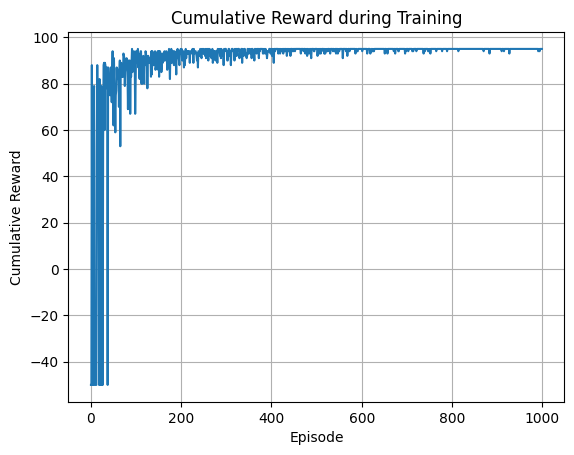

Episode 1: Total Reward: 95
Episode 2: Total Reward: 95
Episode 3: Total Reward: 95
Episode 4: Total Reward: 95
Episode 5: Total Reward: 95
Episode 6: Total Reward: 95
Episode 7: Total Reward: 95
Episode 8: Total Reward: 95
Episode 9: Total Reward: 95
Episode 10: Total Reward: 95


In [58]:
class QLearningAgent:
    def __init__(self, env, learning_rate=0.1, discount_factor=0.9, exploration_rate=1.0, exploration_decay=0.995):
        self.env = env
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.exploration_decay = exploration_decay
        self.q_table = {}
        self.cumulative_rewards = []  # To store cumulative rewards
        self.consecutive_successes_needed =20  # Number of consecutive successful episodes to achieve consistency
        self.consecutive_successes = 0
        self.episodes_to_consistency = None

    def get_q_value(self, state, action):
        return self.q_table.get((state, action), 0.0)

    def update_q_value(self, state, action, reward, next_state):
        best_next_action = max(range(8), key=lambda x: self.get_q_value(next_state, x))
        td_target = reward + self.discount_factor * self.get_q_value(next_state, best_next_action)
        td_error = td_target - self.get_q_value(state, action)
        new_q_value = self.get_q_value(state, action) + self.learning_rate * td_error
        self.q_table[(state, action)] = new_q_value

    def choose_action(self, state):
        if random.random() < self.exploration_rate:
            return random.randint(0, 7)
        else:
            return max(range(8), key=lambda x: self.get_q_value(state, x))

    def train(self, episodes, max_steps_per_episode):
        for episode in range(episodes):
            state = self.env.reset()
            total_reward = 0

            for step in range(max_steps_per_episode):
                action = self.choose_action(state)
                next_state, reward, done = self.env.step(action)
                self.update_q_value(state, action, reward, next_state)
                state = next_state
                total_reward += reward

                if done:
                    break

            self.exploration_rate *= self.exploration_decay
            self.cumulative_rewards.append(total_reward)  # Store cumulative reward

            # Check for consecutive successes
            if reward == 100:  # Reached gold
                self.consecutive_successes += 1
            else:
                self.consecutive_successes = 0

            if self.consecutive_successes == self.consecutive_successes_needed and self.episodes_to_consistency is None:
                self.episodes_to_consistency = episode + 1

            print(f"Episode {episode + 1}: Total Reward: {total_reward}, Exploration Rate: {self.exploration_rate}")

    def plot_cumulative_rewards(self):
        plt.plot(self.cumulative_rewards)
        plt.title('Cumulative Reward during Training')
        plt.xlabel('Episode')
        plt.ylabel('Cumulative Reward')
        plt.grid(True)
        plt.show()

    def play(self, episodes, max_steps_per_episode):
        for episode in range(episodes):
            state = self.env.reset()
            total_reward = 0

            for step in range(max_steps_per_episode):
                action = self.choose_action(state)
                next_state, reward, done = self.env.step(action)
                state = next_state
                total_reward += reward

                if done:
                    break

            print(f"Episode {episode + 1}: Total Reward: {total_reward}")

    def get_cumulative_rewards(self):
        return self.cumulative_rewards

    def get_episodes_to_consistency(self):
        return self.episodes_to_consistency


if __name__ == "__main__":
    env = WumpusWorldEnv()
    agent = QLearningAgent(env)

    # Training the agent
    agent.train(episodes=1000, max_steps_per_episode=50)

    # Plot cumulative rewards
    agent.plot_cumulative_rewards()

    # Playing the game with the trained agent
    agent.play(episodes=10, max_steps_per_episode=50)

##DQN Agent

Episode 1: Total Reward: 67, Exploration Rate: 0.995
Episode 2: Total Reward: -50, Exploration Rate: 0.990025
Episode 3: Total Reward: 52, Exploration Rate: 0.985074875
Episode 4: Total Reward: -50, Exploration Rate: 0.9801495006250001
Episode 5: Total Reward: 86, Exploration Rate: 0.9752487531218751
Episode 6: Total Reward: -50, Exploration Rate: 0.9703725093562657
Episode 7: Total Reward: 69, Exploration Rate: 0.9655206468094844
Episode 8: Total Reward: -50, Exploration Rate: 0.960693043575437
Episode 9: Total Reward: 82, Exploration Rate: 0.9558895783575597
Episode 10: Total Reward: 64, Exploration Rate: 0.9511101304657719
Episode 11: Total Reward: 59, Exploration Rate: 0.946354579813443
Episode 12: Total Reward: 77, Exploration Rate: 0.9416228069143757
Episode 13: Total Reward: -50, Exploration Rate: 0.9369146928798039
Episode 14: Total Reward: -50, Exploration Rate: 0.9322301194154049
Episode 15: Total Reward: 79, Exploration Rate: 0.9275689688183278
Episode 16: Total Reward: 56, 

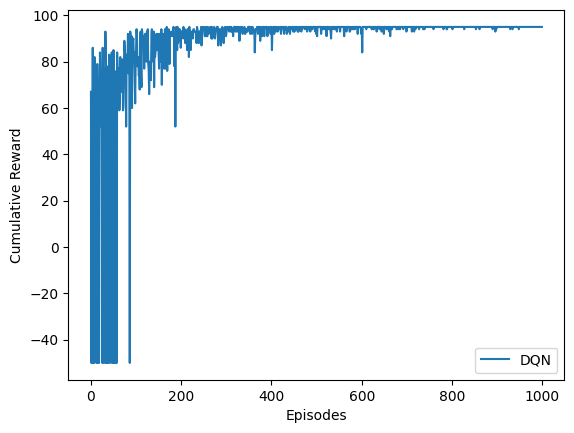

Episode 1: Total Reward: 95
Episode 2: Total Reward: 95
Episode 3: Total Reward: 95
Episode 4: Total Reward: 95
Episode 5: Total Reward: 95
Episode 6: Total Reward: 95
Episode 7: Total Reward: 95
Episode 8: Total Reward: 95
Episode 9: Total Reward: 95
Episode 10: Total Reward: 95


In [7]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import deque
class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = deque(maxlen=capacity)

    def push(self, experience):
        self.memory.append(experience)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


class QNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


class DQNAgent:
    def __init__(self, env, learning_rate=0.1, discount_factor=0.9, exploration_rate=1.0, exploration_decay=0.995,
                 target_update=100, replay_memory_capacity=10000, batch_size=256):
        self.env = env
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.exploration_decay = exploration_decay
        self.target_update = target_update
        self.replay_memory = ReplayMemory(replay_memory_capacity)
        self.batch_size = batch_size

        self.input_size = len(env.reset())
        self.output_size = 8
        self.policy_network = QNetwork(self.input_size, self.output_size)
        self.target_network = QNetwork(self.input_size, self.output_size)
        self.optimizer = optim.Adam(self.policy_network.parameters(), lr=self.learning_rate)

        self.cumulative_rewards = []
        self.steps_done = 0

        # Initialize target network with the same weights as the policy network
        self.update_target_network()
        # Consistency tracking
        self.consecutive_successes_needed = 5
        self.consecutive_successes = 0
        self.episodes_to_consistency = None

    def update_target_network(self):
        self.target_network.load_state_dict(self.policy_network.state_dict())

    def get_q_values(self, state):
        state = torch.tensor(state, dtype=torch.float).unsqueeze(0)
        with torch.no_grad():
            q_values = self.policy_network(state)
        return q_values.numpy()[0]

    def choose_action(self, state):
        if random.random() < self.exploration_rate:
            return random.randint(0, 7)
        else:
            q_values = self.get_q_values(state)
            return np.argmax(q_values)

    def push_to_memory(self, state, action, reward, next_state, done):
        self.replay_memory.push((state, action, reward, next_state, done))

    def sample_from_memory(self):
        return self.replay_memory.sample(self.batch_size)

    def learn_from_memory(self):
        if len(self.replay_memory) < self.batch_size:
            return

        batch = self.sample_from_memory()
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.tensor(states, dtype=torch.float)
        actions = torch.tensor(actions, dtype=torch.long)
        rewards = torch.tensor(rewards, dtype=torch.float)
        next_states = torch.tensor(next_states, dtype=torch.float)
        dones = torch.tensor(dones, dtype=torch.float)

        current_q_values = self.policy_network(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        next_q_values = self.target_network(next_states).max(1)[0]
        expected_q_values = rewards + (1 - dones) * self.discount_factor * next_q_values

        loss = F.smooth_l1_loss(current_q_values, expected_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def train(self, episodes, max_steps_per_episode):
        for episode in range(episodes):
            state = self.env.reset()
            total_reward = 0

            for step in range(max_steps_per_episode):
                action = self.choose_action(state)
                next_state, reward, done = self.env.step(action)
                self.push_to_memory(state, action, reward, next_state, done)

                state = next_state
                total_reward += reward
                self.steps_done += 1

                self.learn_from_memory()

                if done:
                    break

            self.cumulative_rewards.append(total_reward)
            self.exploration_rate *= self.exploration_decay

            # Check for consecutive successes
            if reward == 100:  # Reached gold
                self.consecutive_successes += 1
            else:
                self.consecutive_successes = 0

            if self.consecutive_successes == self.consecutive_successes_needed and self.episodes_to_consistency is None:
                self.episodes_to_consistency = episode + 1

            if episode % self.target_update == 0:
                self.update_target_network()

            print(f"Episode {episode + 1}: Total Reward: {total_reward}, Exploration Rate: {self.exploration_rate}")

    def play(self, episodes, max_steps_per_episode):
        for episode in range(episodes):
            state = self.env.reset()
            total_reward = 0

            for step in range(max_steps_per_episode):
                action = self.choose_action(state)
                next_state, reward, done = self.env.step(action)
                state = next_state
                total_reward += reward

                if done:
                    break

            print(f"Episode {episode + 1}: Total Reward: {total_reward}")

    def get_cumulative_rewards(self):
        return self.cumulative_rewards

    def get_episodes_to_consistency(self):
        return self.episodes_to_consistency


if __name__ == "__main__":
    env = WumpusWorldEnv()

    # Training the DQN agent
    dqn_agent = DQNAgent(env)
    dqn_agent.train(episodes=1000, max_steps_per_episode=50)

    # Plotting the cumulative rewards for the DQN agent
    plt.plot(dqn_agent.cumulative_rewards, label="DQN")
    plt.xlabel('Episodes')
    plt.ylabel('Cumulative Reward')
    plt.legend()
    plt.show()

    # Playing the game with the trained agent
    dqn_agent.play(episodes=10, max_steps_per_episode=50)

#B

Episode 1: Total Reward: -50, Exploration Rate: 0.995
Episode 2: Total Reward: -50, Exploration Rate: 0.990025
Episode 3: Total Reward: 54, Exploration Rate: 0.985074875
Episode 4: Total Reward: -50, Exploration Rate: 0.9801495006250001
Episode 5: Total Reward: -50, Exploration Rate: 0.9752487531218751
Episode 6: Total Reward: -50, Exploration Rate: 0.9703725093562657
Episode 7: Total Reward: 72, Exploration Rate: 0.9655206468094844
Episode 8: Total Reward: -50, Exploration Rate: 0.960693043575437
Episode 9: Total Reward: 51, Exploration Rate: 0.9558895783575597
Episode 10: Total Reward: -50, Exploration Rate: 0.9511101304657719
Episode 11: Total Reward: 60, Exploration Rate: 0.946354579813443
Episode 12: Total Reward: -50, Exploration Rate: 0.9416228069143757
Episode 13: Total Reward: -50, Exploration Rate: 0.9369146928798039
Episode 14: Total Reward: 80, Exploration Rate: 0.9322301194154049
Episode 15: Total Reward: 79, Exploration Rate: 0.9275689688183278
Episode 16: Total Reward: -

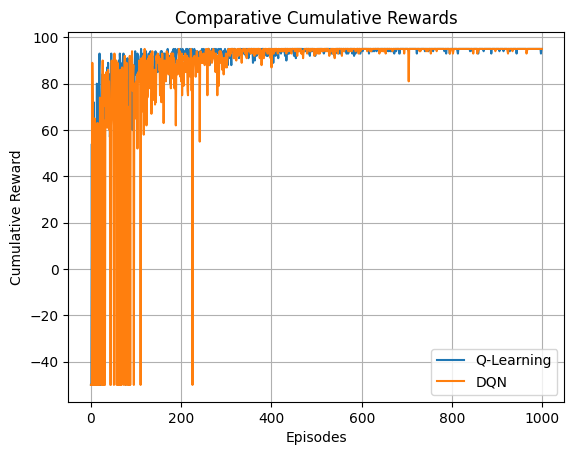

In [87]:
import matplotlib.pyplot as plt

if __name__ == "__main__":
    env = WumpusWorldEnv()

    # Training the Q-Learning agent
    ql_agent = QLearningAgent(env)
    ql_agent.train(episodes=1000, max_steps_per_episode=50)
    ql_cumulative_rewards = ql_agent.get_cumulative_rewards()

    # Training the DQN agent
    dqn_agent = DQNAgent(env)
    dqn_agent.train(episodes=1000, max_steps_per_episode=50)
    dqn_cumulative_rewards = dqn_agent.get_cumulative_rewards()

    # Plotting cumulative rewards for both agents
    plt.plot(ql_cumulative_rewards, label="Q-Learning")
    plt.plot(dqn_cumulative_rewards, label="DQN")
    plt.xlabel('Episodes')
    plt.ylabel('Cumulative Reward')
    plt.title('Comparative Cumulative Rewards')
    plt.legend()
    plt.grid(True)
    plt.show()


In [88]:
import numpy as np

ql_average_reward = np.mean(ql_cumulative_rewards)
print(f"Average reward per episode for Q-Learning: {ql_average_reward}")


Average reward per episode for Q-Learning: 90.154


In [90]:
dqn_average_reward = np.mean(dqn_cumulative_rewards)
print(f"Average reward per episode for DQN: {dqn_average_reward}")


Average reward per episode for DQN: 86.309


In [91]:
if ql_average_reward > dqn_average_reward:
    print("Q-Learning performed better.")
elif ql_average_reward < dqn_average_reward:
    print("DQN performed better.")
else:
    print("Both agents performed equally.")


Q-Learning performed better.


#D

In [59]:
# Printing episodes to consistency
if agent.get_episodes_to_consistency():
    print(f"Agent achieved consistent performance after {agent.get_episodes_to_consistency()} episodes.")
else:
    print("Agent did not achieve consistent performance within the given number of episodes.")


Agent achieved consistent performance after 58 episodes.


In [57]:
# Printing episodes to consistency
if dqn_agent.get_episodes_to_consistency():
    print(f"Agent achieved consistent performance after {dqn_agent.get_episodes_to_consistency()} episodes.")
else:
    print("Agent did not achieve consistent performance within the given number of episodes.")


Agent achieved consistent performance after 102 episodes.
